# CMS Open Data $t\bar{t}$: from data delivery to statistical inference

We are using [2015 CMS Open Data](https://cms.cern/news/first-cms-open-data-lhc-run-2-released) in this demonstration to showcase an analysis pipeline.
It features data delivery and processing, histogram construction and visualization, as well as statistical inference.

This notebook was developed in the context of the [IRIS-HEP AGC tools 2022 workshop](https://indico.cern.ch/e/agc-tools-2).
This work was supported by the U.S. National Science Foundation (NSF) Cooperative Agreement OAC-1836650 (IRIS-HEP).

This is a **technical demonstration**.
We are including the relevant workflow aspects that physicists need in their work, but we are not focusing on making every piece of the demonstration physically meaningful.
This concerns in particular systematic uncertainties: we capture the workflow, but the actual implementations are more complex in practice.
If you are interested in the physics side of analyzing top pair production, check out the latest results from [ATLAS](https://twiki.cern.ch/twiki/bin/view/AtlasPublic/TopPublicResults) and [CMS](https://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/)!
If you would like to see more technical demonstrations, also check out an [ATLAS Open Data example](https://indico.cern.ch/event/1076231/contributions/4560405/) demonstrated previously.

This notebook implements most of the analysis pipeline shown in the following picture, using the tools also mentioned there:
![ecosystem visualization](utils/ecosystem.png)

### Data pipelines

To be a bit more precise, we are going to be looking at three different data pipelines:
![processing pipelines](utils/processing_pipelines.png)

### Imports: setting up our environment

In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import awkward as ak

import cabinetry
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from func_adl import ObjectStream
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

### Configuration: number of files and data delivery path

The number of files per sample set here determines the size of the dataset we are processing.
There are 9 samples being used here, all part of the 2015 CMS Open Data release.
They are pre-converted from miniAOD files into ntuple format, similar to nanoAODs.
More details about the inputs can be found [here](https://github.com/iris-hep/analysis-grand-challenge/tree/main/datasets/cms-open-data-2015).

The table below summarizes the amount of data processed depending on the `N_FILES_MAX_PER_SAMPLE` setting.

| setting | number of files | total size |
| --- | --- | --- |
| `10` | 90 | 15.6 GB |
| `100` | 850 | 150 GB |
| `500` | 3545| 649 GB |
| `1000` | 5864 | 1.05 TB |
| `-1` | 22635 | 3.44 TB |

The input files are all in the 100–200 MB range.

Some files are also rucio-accessible (with ATLAS credentials):

| dataset | number of files | total size |
| --- | --- | --- |
| `user.ivukotic:user.ivukotic.ttbar__nominal` | 7066 | 1.46 TB |
| `user.ivukotic:user.ivukotic.ttbar__scaledown` | 902 | 209 GB |
| `user.ivukotic:user.ivukotic.ttbar__scaleup` | 917 | 191 GB |
| `user.ivukotic:user.ivukotic.ttbar__ME_var` | 438 | 103 GB |
| `user.ivukotic:user.ivukotic.ttbar__PS_var` | 443 | 100 GB |
| `user.ivukotic:user.ivukotic.single_top_s_chan__nominal` | 114 | 11 GB |
| `user.ivukotic:user.ivukotic.single_top_t_chan__nominal` | 2506 | 392 GB |
| `user.ivukotic:user.ivukotic.single_top_tW__nominal` | 50 | 9 GB |
| `user.ivukotic:user.ivukotic.wjets__nominal` | 10199 | 1.13 TB |
| total | 22635 | 3.61 TB |

The difference in total file size is presumably due to the different storages, which report slightly different sizes.

When setting the `PIPELINE` variable below to `"servicex_databinder"`, the `N_FILES_MAX_PER_SAMPLE` variable is ignored and all files are processed.

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 1

# pipeline to use:
# - "coffea" for pure coffea setup
# - "servicex_processor" for coffea with ServiceX processor
# - "servicex_databinder" for downloading query output and subsequent standalone coffea
PIPELINE = "coffea"

# enable Dask (may not work yet in combination with ServiceX outside of coffea-casa)
USE_DASK = not True

# ServiceX behavior: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = True

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "local"

### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

In [3]:
processor_base = processor.ProcessorABC if (PIPELINE != "servicex_processor") else servicex.Analysis

# functions creating systematic variations
def flat_variation(ones):
    # 2.5% weight variations
    return (1.0 + np.array([0.025, -0.025], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (7.5% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.075, -0.075]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        #### systematics
        # example of a simple flat weight variation, using the coffea nanoevents systematics feature
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.jet.pt)

        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:

            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            selected_electrons = events.electron[events.electron.pt > 25]
            selected_muons = events.muon[events.muon.pt > 25]
            jet_filter = events.jet.pt * events[pt_var] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.jet[jet_filter]

            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]

            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
                    selected_jets_region = selected_jets[region_filter]
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = events[event_filters][region_filter][pt_var] if "res" not in pt_var else events[pt_var][jet_filter][event_filters][region_filter]
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

                elif region == "4j2b":
                    region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
                    selected_jets_region = selected_jets[region_filter]

                    if PIPELINE == "servicex_processor":
                        import vector

                        vector.register_awkward()

                        # wrap into a four-vector object to allow addition
                        selected_jets_region = ak.zip(
                            {
                                "pt": selected_jets_region.pt, "eta": selected_jets_region.eta, "phi": selected_jets_region.phi,
                                "mass": selected_jets_region.mass, "btag": selected_jets_region.btag,
                            },
                            with_name="Momentum4D",
                        )

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=variation, weight=xsec_weight
                        )

                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                if len(observable):
                                    weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, i_dir]
                                else:
                                    weight_variation = 1 # no events selected
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=pt_var, weight=xsec_weight
                        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### AGC `coffea` schema

When using `coffea`, we can benefit from the schema functionality to group columns into convenient objects.
This schema is taken from [mat-adamec/agc_coffea](https://github.com/mat-adamec/agc_coffea).

In [4]:
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False, use_local=True)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [input/ttbar_nominal/0, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 41812, 'xsec': 729.84}
}


### ServiceX-specific functionality: query setup

Define the func_adl query to be used for the purpose of extracting columns and filtering.

In [6]:
def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: no filter, select relevant lepton and jet columns
    """
    return source.Select(lambda e: {
                                    "electron_pt": e.electron_pt,
                                    "muon_pt": e.muon_pt,
                                    "jet_pt": e.jet_pt,
                                    "jet_eta": e.jet_eta,
                                    "jet_phi": e.jet_phi,
                                    "jet_mass": e.jet_mass,
                                    "jet_btag": e.jet_btag,
                                   }
                        )

### Standalone ServiceX for subsequent `coffea` processing

Using `servicex-databinder`, we can execute a query and download the output.
As the files are currently accessible through `rucio` only with ATLAS credentials, you need to use an ATLAS ServiceX instance to run this (for example via the UChicago coffea-casa analysis facility).

In [7]:
if PIPELINE == "servicex_databinder":
    from servicex_databinder import DataBinder
    t0 = time.time()

    # query for events with at least 4 jets with 25 GeV, at least one b-tag, and exactly one electron or muon with pT > 25 GeV
    # returning columns required for subsequent processing
    query_string = """Where(
        lambda event: event.electron_pt.Where(lambda pT: pT > 25).Count() + event.muon_pt.Where(lambda pT: pT > 25).Count() == 1
        ).Where(lambda event: event.jet_pt.Where(lambda pT: pT > 25).Count() >= 4
        ).Where(lambda event: event.jet_btag.Where(lambda btag: btag > 0.5).Count() >= 1
        ).Select(
             lambda e: {"electron_pt": e.electron_pt, "muon_pt": e.muon_pt,
                        "jet_pt": e.jet_pt, "jet_eta": e.jet_eta, "jet_phi": e.jet_phi, "jet_mass": e.jet_mass, "jet_btag": e.jet_btag}
    )"""

    sample_names = ["ttbar__nominal", "ttbar__scaledown", "ttbar__scaleup", "ttbar__ME_var", "ttbar__PS_var",
                    "single_top_s_chan__nominal", "single_top_t_chan__nominal", "single_top_tW__nominal", "wjets__nominal"]
    sample_names = ["single_top_s_chan__nominal"]  # for quick tests: small dataset with only 50 files
    sample_list = []

    for sample_name in sample_names:
        sample_list.append({"Name": sample_name, "RucioDID": f"user.ivukotic:user.ivukotic.{sample_name}", "Tree": "events", "FuncADL": query_string})


    databinder_config = {
                            "General": {
                                           "ServiceXBackendName": "uproot",
                                            "OutputDirectory": "outputs_databinder",
                                            "OutputFormat": "root",
                                            "IgnoreServiceXCache": SERVICEX_IGNORE_CACHE
                            },
                            "Sample": sample_list
                        }

    sx_db = DataBinder(databinder_config)
    out = sx_db.deliver()
    print(f"execution took {time.time() - t0:.2f} seconds")

    # update list of fileset files, pointing to ServiceX output for subsequent processing
    # for process in fileset.keys():
    #     if out.get(process):
    #         fileset[process]["files"] = out[process]

### Execute the data delivery pipeline

What happens here depends on the configuration setting for `PIPELINE`:
- when set to `servicex_processor`, ServiceX will feed columns to `coffea` processors, which will asynchronously process them and accumulate the output histograms,
- when set to `coffea`, processing will happen with pure `coffea`,
- if `PIPELINE` was set to `servicex_databinder`, the input data has already been pre-processed and will be processed further with `coffea`.

In [8]:
t0 = time.time()

if PIPELINE == "coffea":
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.FuturesExecutor()

    from coffea.nanoevents.schemas.schema import auto_schema
    schema = AGCSchema if PIPELINE == "coffea" else auto_schema
    run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={})

    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    all_histograms = all_histograms["hist"]

elif PIPELINE == "servicex_processor":
    # in a notebook:
    all_histograms = await utils.produce_all_histograms(fileset, get_query, TtbarAnalysis, use_dask=USE_DASK, ignore_cache=SERVICEX_IGNORE_CACHE)

    # as a script:
    # async def produce_all_the_histograms():
    #    return await utils.produce_all_histograms(fileset, get_query, TtbarAnalysis, use_dask=USE_DASK, ignore_cache=SERVICEX_IGNORE_CACHE)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms())

elif PIPELINE == "servicex_databinder":
    # needs a slightly different schema, not currently implemented
    raise NotImplementedError("further processing of this method is not currently implemented")
    
print(f"\nexecution took {time.time() - t0:.2f} seconds")

Preprocessing  11% ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/9 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/afs/cern.ch/user/a/afalko/private/env/lib64/python3.8/site-packages/uproot/source/file.py", line 112, in _open
    self._file = numpy.memmap(self._file_path, dtype=self._dtype, mode="r")
  File "/afs/cern.ch/user/a/afalko/private/env/lib64/python3.8/site-packages/numpy/core/memmap.py", line 228, in __new__
    f_ctx = open(os_fspath(filename), ('r' if mode == 'c' else mode)+'b')
FileNotFoundError: [Errno 2] No such file or directory: 'input/ttbar_nominal/0'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/afs/cern.ch/user/a/afalko/private/env/lib64/python3.8/site-packages/uproot/source/file.py", line 36, in __init__
    self._file = open(self._file_path, "rb")
FileNotFoundError: [Errno 2] No such file or directory: 'input/ttbar_nominal/0'

During handling of the above exception, another exception occurred:

Traceback (most recent

FileNotFoundError: file not found

    'input/ttbar_nominal/0'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
         Examples: Path("rel:/file.root"), Path("/abs/path:stuff.root")

Functions that accept many files (uproot.iterate, etc.) also allow:
   * glob syntax in str/bytes and pathlib.Path.
         Examples: Path("rel/*.root"), "/abs/*.root:tdirectory/ttree"
   * dict: keys are filesystem paths, values are objects-within-ROOT paths.
         Example: {"/data_v1/*.root": "ttree_v1", "/data_v2/*.root": "ttree_v2"}
   * already-open TTree objects.
   * iterables of the above.


### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

In [ ]:
utils.set_style()

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

In [ ]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("$m_{bjj}$ [Gev]");

Our top reconstruction approach ($bjj$ system with largest $p_T$) has worked!

Let's also have a look at some systematic variations:
- b-tagging, which we implemented as jet-kinematic dependent event weights,
- jet energy variations, which vary jet kinematics, resulting in acceptance effects and observable changes.

We are making of [UHI](https://uhi.readthedocs.io/) here to re-bin.

In [ ]:
# b-tagging variations
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_0_up"].plot(label="NP 1", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_1_up"].plot(label="NP 2", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_2_up"].plot(label="NP 3", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_3_up"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("HT [GeV]")
plt.title("b-tagging variations");

In [ ]:
# jet energy scale variations
all_histograms[:, "4j2b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms[:, "4j2b", "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms[:, "4j2b", "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");

### Save histograms to disk

We'll save everything to disk for subsequent usage.
This also builds pseudo-data by combining events from the various simulation setups we have processed.

In [ ]:
utils.save_histograms(all_histograms, fileset, "histograms_local.root")

### Statistical inference

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.

In [ ]:
config = cabinetry.configuration.load("cabinetry_config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)
cabinetry.workspace.save(ws, "workspace.json")

We can inspect the workspace with `pyhf`, or use `pyhf` to perform inference.

In [ ]:
!pyhf inspect workspace.json | head -n 20

                  Summary       
            ------------------  
               channels  2
                samples  5
             parameters  14
              modifiers  14

               channels  nbins
             ----------  -----
                4j1b CR   11  
                4j2b SR   11  

                samples
             ----------
                 W+jets
  single top, s-channel
  single top, t-channel
                     tW
                  ttbar



Let's try out what we built: the next cell will perform a maximum likelihood fit of our statistical model to the pseudodata we built.

W MnPosDef Matrix forced pos-def by adding to diagonal 0.0088349


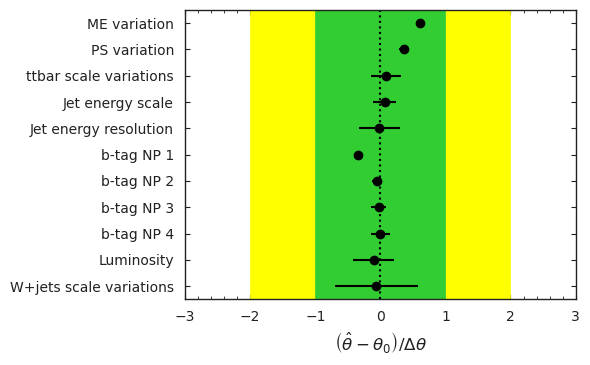

In [ ]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

For this pseudodata, what is the resulting ttbar cross-section divided by the Standard Model prediction?

In [ ]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 1.020 +/- 0.014


Let's also visualize the model before and after the fit, in both the regions we are using.
The binning here corresponds to the binning used for the fit.

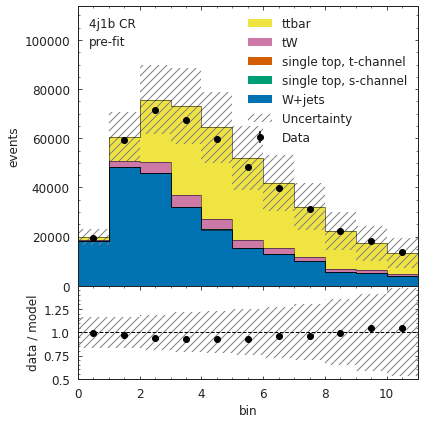

In [ ]:
model_prediction = cabinetry.model_utils.prediction(model)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True)
figs[0]["figure"]

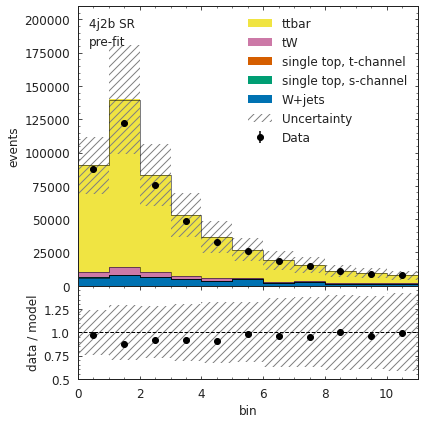

In [ ]:
figs[1]["figure"]

We can see very good post-fit agreement.

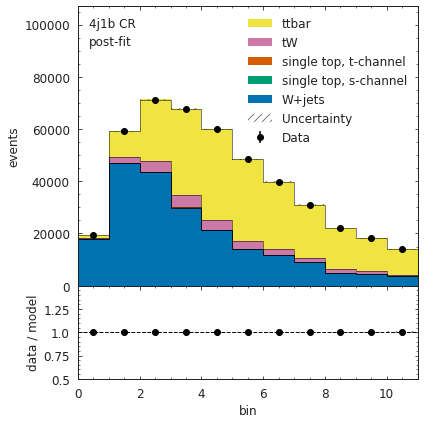

In [ ]:
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction_postfit, data, close_figure=True)
figs[0]["figure"]

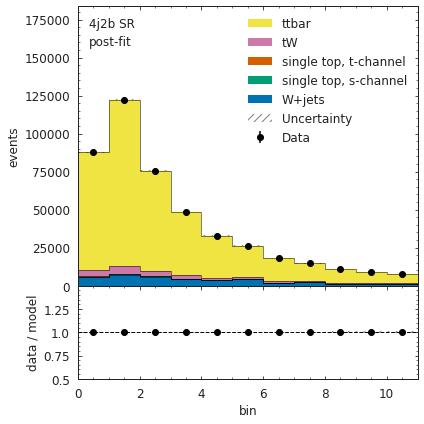

In [ ]:
figs[1]["figure"]

### What is next?

Our next goals for this pipeline demonstration are:
- making this analysis even **more feature-complete**,
- **addressing performance bottlenecks** revealed by this demonstrator,
- **collaborating** with you!

Please do not hesitate to get in touch if you would like to join the effort, or are interested in re-implementing (pieces of) the pipeline with different tools!

Our mailing list is analysis-grand-challenge@iris-hep.org, sign up via the [Google group](https://groups.google.com/a/iris-hep.org/g/analysis-grand-challenge).